In [9]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np



In [ ]:
# Contrucción del servicio


grafo = nx.Graph()


servicios = [
    {
        'id': 'servicio1',
        'tipo': 'instalación',
        'tiempo': 2,
        'ubicacion': (21.12, -101.68),
        'color': 'rojo',
        'bloqueado': False,
        'flotilla': None
    },
    {
        'id': 'servicio2',
        'tipo': 'instalación',
        'tiempo': 2,
        'ubicacion': (21.12, -101.67),
        'color': 'rojo',
        'bloqueado': False,
        'flotilla': None
    },
    {
        'id': 'servicio3',
        'tipo': 'instalación',
        'tiempo': 2,
        'ubicacion': (21.13, -101.67),
        'color': 'rojo',
        'bloqueado': False,
        'flotilla': None
    },
    {
        'id': 'servicio4',
        'tipo': 'instalación',
        'tiempo': 2,
        'ubicacion': (21.13, -101.68),
        'color': 'rojo',
        'bloqueado': False,
        'flotilla': None
    },
    {
        'id': 'servicio5',
        'tipo': 'instalación',
        'tiempo': 2,
        'ubicacion': (21.14, -101.68),
        'color': 'rojo',
        'bloqueado': False,
        'flotilla': None
    }
]

for servicio in servicios:
    grafo.add_node(
        servicio['id'],
        tipo=servicio['tipo'],
        tiempo=servicio['tiempo'],
        ubicacion=servicio['ubicacion'],
        color=servicio['color'],
        bloqueado=servicio['bloqueado'],
        flotilla=servicio['flotilla']
    )


### Fórmulas utilizadas para distancias geográficas 🌍:

#### 1. **Distancia Haversine** 🌐
La fórmula más común para calcular distancias entre dos puntos en la Tierra es la del **Haversine**, que usa latitud y longitud (en grados).

**Fórmula:**
\[
a = \sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\Delta \lambda}{2}\right)
\]
\[
c = 2 \cdot \text{atan2}\left(\sqrt{a}, \sqrt{1-a}\right)
\]
\[
d = R \cdot c
\]

$\text{atan2}$ es la función arcotangente con dos argumentos, y \(R\) es el radio de la Tierra.

- \(\phi_1, \phi_2\): Latitudes de los puntos 1 y 2 en **radianes**.
- \(\lambda_1, \lambda_2\): Longitudes de los puntos 1 y 2 en **radianes**.
- \(\Delta \phi = \phi_2 - \phi_1\): Diferencia de latitudes.
- \(\Delta \lambda = \lambda_2 - \lambda_1\): Diferencia de longitudes.
- \(R\): Radio de la Tierra (usualmente 6,371 km).

El resultado \(d\) es la distancia entre los puntos, siguiendo la superficie de la esfera.

#### 2. **Distancia euclidiana para puntos cercanos** 🛠️
Para distancias muy cortas (dentro de una ciudad, por ejemplo), la curvatura de la Tierra puede ignorarse, y **sí podrías usar** una fórmula simplificada como:
\[
\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
\]
Pero para esto necesitas convertir latitudes y longitudes a un sistema de coordenadas cartesianas local (como UTM).

#### Ejemplo práctico 🧮
Imagina que tienes dos puntos en coordenadas geográficas:
- Punto A: \( \text{lat}_1 = 19.4326^\circ\), \( \text{lon}_1 = -99.1332^\circ\) (CDMX).
- Punto B: \( \text{lat}_2 = 34.0522^\circ\), \( \text{lon}_2 = -118.2437^\circ\) (Los Ángeles).

Convirtiendo a radianes y aplicando la fórmula de Haversine, obtendrás la distancia aproximada **en kilómetros**.

#### ¿Por qué no usar la fórmula simple? ✋
- La Tierra no es perfectamente esférica (es un esferoide oblato), aunque para la mayoría de las aplicaciones la diferencia es mínima.
- Ignorar la curvatura introduce errores significativos para distancias grandes.


In [10]:


# Datos de ubicación de los servicios
ubicaciones = np.array([[21.12, -101.68], [21.15, -101.65], [21.20, -101.70],[21.10, -101.75], [21.05, -101.80], [21.00, -101.85]])
# Generar 35 ubicaciones diferentes
np.random.seed(0)
ubicaciones = np.random.uniform(low=[21.00, -101.85], high=[21.20, -101.65], size=(35, 2))

# Crear 3 clusters
kmeans = KMeans(n_clusters=6, random_state=0).fit(ubicaciones)
clusters = kmeans.labels_
print("Cluster asignado a cada servicio:", clusters)



Cluster asignado a cada servicio: [5 5 5 5 0 0 5 1 4 0 0 5 4 4 2 4 5 4 5 0 2 3 5 1 2 2 3 1 3 2 1 3 2 3 3]


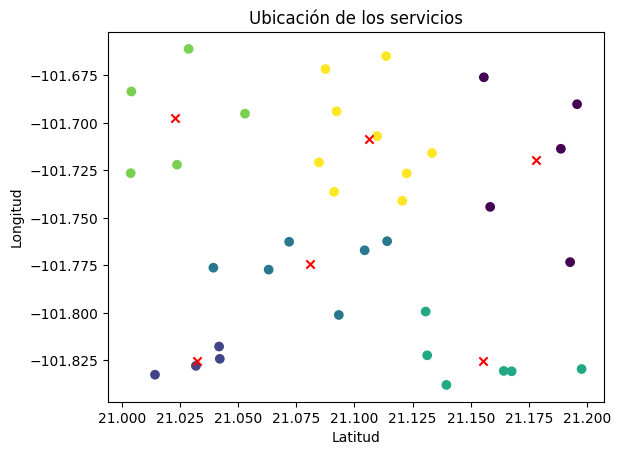

In [11]:
# Hacemos visual nuestro algoritmo

plt.scatter(ubicaciones[:, 0], ubicaciones[:, 1], c=clusters)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
plt.title("Ubicación de los servicios")
plt.xlabel("Latitud")
plt.ylabel("Longitud")
plt.show()